![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [ ]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

##**Conclusiones del estudiante**

*En general, se identifica que hay una mayor cantidad de alquileres en promedio en los dias laborales vs los dias no laborales, sin embargo, aun es necesario descartar aquellos dias considerados laborales (Lunes a Viernes) que son feriados.*

In [ ]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

##**Conclusiones del estudiante**

*Se idenfica que las horas de mayor demanda coinciden con las horas de entrada y salida tradicionales de los trabajos [7AM-9AM], [12-1PM], [5-6PM], esto considerando que posiblemente las personas que se desplazan desde o hacia sus lugares de trabajo, tambien estén utilizando el servicio de alquiler de bicicletas.*

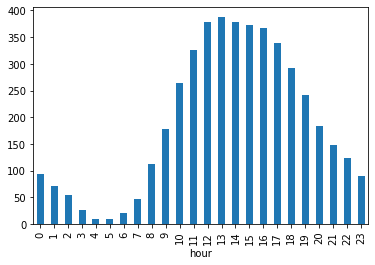

In [ ]:
#Análisis del comportamiento por hora en dias NO laborales
bikes[bikes['workingday']==0].groupby('hour').total.mean().plot.bar()

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

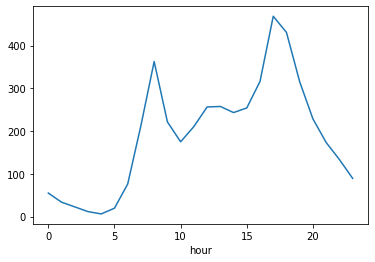

In [ ]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

##**Conclusiones del estudiante**

*Debido a que 5 de cada 7 días son considerados como laborables, la distribución general de estos datos es muy similar a la distribución o el comportamiento encontrado en la grafica de la celda 2.3, en donde se analizan exclusivamente estos dias.*

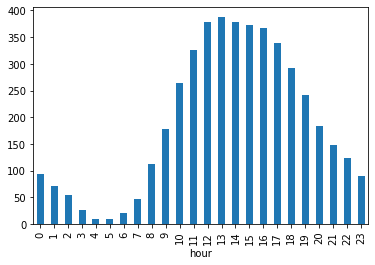

In [ ]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 

bikes[bikes['workingday']==0].groupby('hour').total.mean().plot.bar()

##**Conclusiones del estudiante**

*En los días NO laborales se logra visualizar un comportamiento mas estable durante todo el día, concentrando la mayor parte de la demanda entre las 10 de la mañana y las 7 de la noche.*

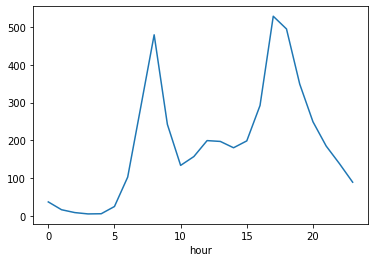

In [ ]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 

bikes[bikes['workingday']==1].groupby('hour').total.mean().plot()

##**Conclusiones del estudiante**

*Al tener un comportamiento muy similar al encontrado en lso datos generalizados, es posible determinar que la demanda en los dias laborales se concentra principalmente en los horarios de desplazamiento desde y hacia los sitios de trabajo, esto a partir de los horarios de los alquileres.*

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [ ]:
# Celda 3
features = ['hour', 'workingday']
todas = ['hour', 'workingday', 'total']
for ft in todas:
    bikes[ft] = pd.to_numeric(bikes[ft])
X = bikes[features]
Y = bikes['total']
regresion = LinearRegression()  
regresion.fit(X, Y) 
regresion.coef_

array([10.49206282,  4.07248627])

##**Conclusiones del estudiante**

*Para este caso particular, la regresion lineal no está en la capacidad de predecir de forma adecuada la demanda de bicicletas de acuerdo a si es dia entre semana o fin de semana y la hora, esto se debe a que los datos no se comportan de dicha forma y adicionalmente, la hora toma un peso debido a que se trata de datos numericos, eso significa que las 23hrs tendran un peso muy superior a las 0 hrs, esto a pesar de que son horas muy similares al final del ejercicio, la regresion lineal no logra predecir de forma adecuada.*

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [ ]:
class RegresionManual():
    def __init__(
        self, 
        X: pd.DataFrame,
        Y: list,
        min_samples_split=20,
        max_depth=5,
        depth=0,
        node_type='raiz',
        rule=""
    ):
        self.Y = Y 
        self.X = X
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.depth = depth
        self.features = list(self.X.columns)
        self.node_type = node_type
        self.rule = rule 
        self.ymean = np.mean(Y)
        self.residuals = self.Y - self.ymean
        self.mse = self.get_mse(Y, self.ymean)
        self.n = len(Y)
        self.left = None 
        self.right = None 
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def get_mse(ytrue, yhat):
        return np.sum((ytrue - yhat) ** 2) / len(ytrue)

    @staticmethod
    def ma(x: np.array, window: int):
        return np.convolve(x, np.ones(window), 'valid') / window

    def best_split(self):
        df = self.X.copy()
        df['Y'] = self.Y
        #Error Inicial (Como en el ejemplo del profesor)
        mse_base = self.mse
        best_feature = None
        best_value = None

        for feature in self.features:
            Xdf = df.dropna().sort_values(feature)
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                left_y = Xdf[Xdf[feature]<value]['Y'].values
                right_y = Xdf[Xdf[feature]>=value]['Y'].values
                left_mean = np.mean(left_y)
                right_mean = np.mean(right_y)
                res_left = left_y - left_mean 
                res_right = right_y - right_mean
                r = np.concatenate((res_left, res_right), axis=None)
                mse_split = np.sum(r ** 2) / len(r)

                if mse_split < mse_base:
                    best_feature = feature
                    best_value = value 
                    mse_base = mse_split

        return (best_feature, best_value)

    def tree_grow(self):
        df = self.X.copy()
        df['Y'] = self.Y
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                self.best_feature = best_feature
                self.best_value = best_value
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()
                left = RegresionManual(
                    Y = left_df['Y'].values.tolist(), 
                    X = left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='izquierda',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.tree_grow()

                right = RegresionManual(
                    Y = right_df['Y'].values.tolist(), 
                    X = right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='derecha',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.tree_grow()

    def print_info(self):
        const = int(self.depth * 4 ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'raiz':
            print("Nodo raiz")
        else:
            print(f"{spaces} Regla en el nodo: {self.rule}")
        print(f"{' ' * const}   -> MSE del nodo: {round(self.mse, 2)}")
        print(f"{' ' * const}   -> Cantidad de observaciones: {self.n}")
        print(f"{' ' * const}   -> Predicción del nodo: {round(self.ymean, 3)}")   

    def print_tree(self):
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

In [ ]:
test2 = RegresionManual(Y = Y.values.tolist(),  X = X, max_depth=2, min_samples_split=2)
test2.tree_grow()

In [ ]:
test2.print_tree()

Nodo raiz
   -> MSE del nodo: 32810.3
   -> Cantidad de observaciones: 10886
   -> Predicción del nodo: 191.574
-------- Regla en el nodo: hour <= 6.5
           -> MSE del nodo: 1565.56
           -> Cantidad de observaciones: 3139
           -> Predicción del nodo: 32.582
---------------- Regla en el nodo: hour <= 5.5
                   -> MSE del nodo: 945.78
                   -> Cantidad de observaciones: 2684
                   -> Predicción del nodo: 25.178
---------------- Regla en el nodo: hour > 5.5
                   -> MSE del nodo: 2990.46
                   -> Cantidad de observaciones: 455
                   -> Predicción del nodo: 76.259
-------- Regla en el nodo: hour > 6.5
           -> MSE del nodo: 31077.58
           -> Cantidad de observaciones: 7747
           -> Predicción del nodo: 255.996
---------------- Regla en el nodo: hour <= 20.5
                   -> MSE del nodo: 32410.31
                   -> Cantidad de observaciones: 6379
                   -> Predi

##**Conclusiones del estudiante**

*En el punto 4, el proceso de generación de un arbol de forma manual es mucho mas exhausto que generarlo mediante librerias prediseñadas, sin embargo, se puede llegar a tener un desempeño similar o igual al desempeño logrado por librerias como sklearn, esto considerando que en el proceso manual, la optimización de hiperparametros es mucho mas compleja que realizarla mediante librerias, como se puede evidenciar en el proceso descrito previamente, para un arbol con profundidad 2, se logra el mismo desempeño que sklearn*

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
rendimiento = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    rendimiento.append(cross_val_score(clf, X, Y, cv=10, scoring='neg_mean_squared_error').mean())



Text(0, 0.5, 'MSE')

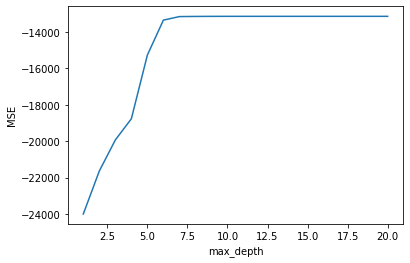

In [ ]:
plt.plot(max_depth_range, rendimiento)
plt.xlabel('max_depth')
plt.ylabel('Metricas')

In [ ]:
sorted(zip(rendimiento, max_depth_range))[::-1][0]

(-13143.121883295113, 20)

In [ ]:
clf = DecisionTreeRegressor(max_depth=2, random_state=1)
clf.fit(X, Y)

DecisionTreeRegressor(max_depth=2, random_state=1)

[Text(0.5, 0.8333333333333334, 'X[0] <= 6.5\nsquared_error = 32810.299\nsamples = 10886\nvalue = 191.574'),
 Text(0.25, 0.5, 'X[0] <= 5.5\nsquared_error = 1565.559\nsamples = 3139\nvalue = 32.582'),
 Text(0.125, 0.16666666666666666, 'squared_error = 945.78\nsamples = 2684\nvalue = 25.178'),
 Text(0.375, 0.16666666666666666, 'squared_error = 2990.465\nsamples = 455\nvalue = 76.259'),
 Text(0.75, 0.5, 'X[0] <= 20.5\nsquared_error = 31077.582\nsamples = 7747\nvalue = 255.996'),
 Text(0.625, 0.16666666666666666, 'squared_error = 32410.315\nsamples = 6379\nvalue = 282.555'),
 Text(0.875, 0.16666666666666666, 'squared_error = 6236.566\nsamples = 1368\nvalue = 132.152')]

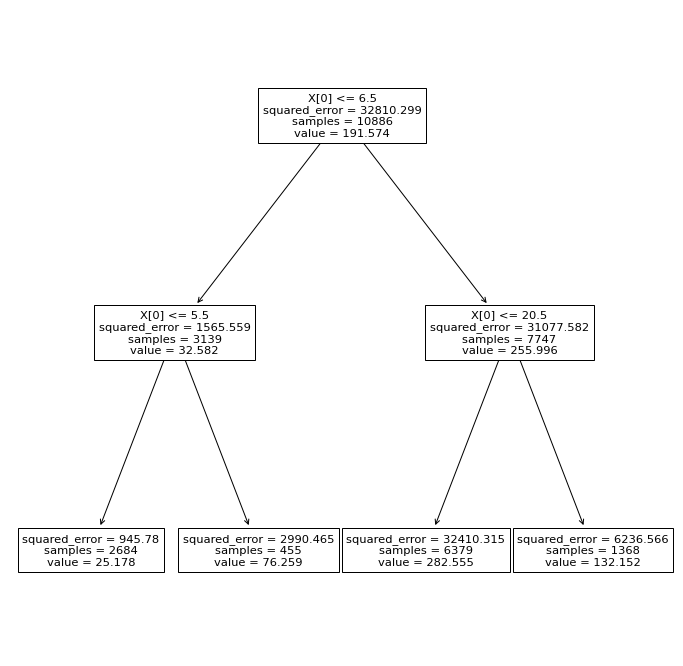

In [ ]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf)

##**Conclusiones del estudiante**

*Con el objetivo de comprobar el desempeño del arbol manual y el que se encuentra basado en librerias, se hace impresion de este con el mismo nivel de profundidad.*

**Por favor revisar la siguiente celda para verificar el arbol con la profundidad recomendada por el optimizador**

[Text(0.46412037037037035, 0.95, 'X[0] <= 6.5\nsquared_error = 32810.299\nsamples = 10886\nvalue = 191.574'),
 Text(0.1814814814814815, 0.85, 'X[0] <= 5.5\nsquared_error = 1565.559\nsamples = 3139\nvalue = 32.582'),
 Text(0.1259259259259259, 0.75, 'X[0] <= 1.5\nsquared_error = 945.78\nsamples = 2684\nvalue = 25.178'),
 Text(0.05925925925925926, 0.65, 'X[1] <= 0.5\nsquared_error = 1643.407\nsamples = 909\nvalue = 44.51'),
 Text(0.02962962962962963, 0.55, 'X[0] <= 0.5\nsquared_error = 1822.063\nsamples = 290\nvalue = 83.2'),
 Text(0.014814814814814815, 0.45, 'squared_error = 2208.057\nsamples = 145\nvalue = 94.49'),
 Text(0.044444444444444446, 0.45, 'squared_error = 1181.157\nsamples = 145\nvalue = 71.91'),
 Text(0.08888888888888889, 0.55, 'X[0] <= 0.5\nsquared_error = 529.872\nsamples = 619\nvalue = 26.384'),
 Text(0.07407407407407407, 0.45, 'squared_error = 690.648\nsamples = 310\nvalue = 36.732'),
 Text(0.1037037037037037, 0.45, 'squared_error = 153.382\nsamples = 309\nvalue = 16.003'

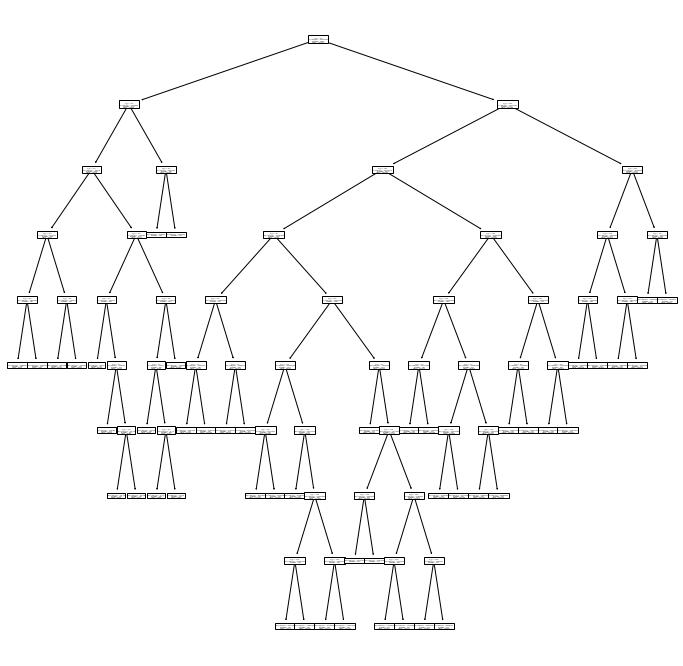

In [ ]:
clf = DecisionTreeRegressor(max_depth=20, random_state=1)
clf.fit(X, Y)
plt.figure(figsize=(12,12))
tree.plot_tree(clf)

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [256]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [257]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [258]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
#Celda 6

max_depth_range = range(1, 21)
accuracy_scores = []
f1_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    f1_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1').mean())

clf = LogisticRegression().fit(X_train, y_train)
metricas = clf.score(X_test, y_test)

plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

plt.plot(max_depth_range, f1_scores)
plt.xlabel('max_depth')
plt.ylabel('F1')

plt.legend(['Accuracy', 'F1'])
plt.title('Arbol de decisión, optimización via max_depth')

from sklearn.metrics import *

f1 = f1_score(y_test, clf.predict(X_test))
acc = accuracy_score(y_test, clf.predict(X_test))

print(f'Regresion logistica: \n F1 -> {f1} \n Accuracy -> {acc} \n\n')

##**Conclusiones del estudiante**



### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9